In [1]:
import numpy as np
import math
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 
import os.path
import scipy as scp
from scipy.interpolate import interp1d
import time


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
## Saving results to a folder
n_folder = 24
save = 0
# 0: off, 1: save in folder n_folder

In [3]:
# Variables --> TODO: file jameson
tones = [100]
angles = np.arange(-90,100,15)
time_sim = 10 #ms
ANF_device = 'SPG' #'SPG' #PulsePacket Generator vs Sinsoidal Poisson Generator
ild_on = 1 #simulation with ILDs or only ITDs input
gauss_on = 1 #for pure tone stimulation, inclusion of co

#Sensible parameters 
ild_values = [10,55,100] #spikes #num of spikes for PPG
sdev = 0.1 #ms #Standard Deviation for PPG spikes
ild_rates = [1000,1250,3000] #Hz #rates for SPG, Kiang: [100,125,300]
noise_rate = 0 # Hz #valid for both types

MNTBCs2LSO_weight = -2.0 #-8, #-16
delays_mso = [1,1.3,1,0.45,0.44] #ms
taus = np.zeros(4)
taus[:] = [0.2, 0.1, 0.2, 0.01] #taus40: [0.2, 0.1, 0.5, 0.1] , #taus15: [0.2, 0.1, 0.2, 0.01]

In [4]:
def create_spectro(tone): #TODO: aggiungere più toni o toni di durata variabile

    channel_x = np.where(freq>=tone)[0][0]
    spectro = np.zeros((3500,time_sim))
    amplitudes = np.round(stats.norm.pdf(np.linspace(-1, 1, 21) , 0, 1.0/(math.sqrt(2*math.pi)*1)),2)
    
    if(gauss_on):
        if(channel_x<10):
            spectro[channel_x:channel_x+10+1,:] = amplitudes[10:].reshape(11,1)*np.ones((11, time_sim))
            spectro[0:channel_x+1, :] = amplitudes[10-channel_x:11].reshape(channel_x+1,1)*np.ones((channel_x+1, time_sim))
        else:
            if(channel_x>3489):
                spectro[channel_x-10:channel_x+1] = amplitudes[:11].reshape(11,1)*np.ones((11, time_sim))
                spectro[channel_x:] = amplitudes[10:10+3500-channel_x].reshape(3500-channel_x,1)*np.ones((3500-channel_x, time_sim))
            else:
                spectro[channel_x - 10 : channel_x + 10 + 1, :] = amplitudes.reshape(21,1)*np.ones((21, time_sim))
    else:
        spectro[channel_x, :] = np.ones(time_sim)
        
    return spectro

In [5]:
def compute_ild_functions_ppg(): #TODO: differentiate for different frequencies
    x_values = np.array([-90,0,90])

    if(ild_on):
        y_values = ild_values
    else:
        y_values =  np.repeat(ild_values[1],3)

    r_function = interp1d(x_values, y_values, kind='linear')
    l_function = interp1d(x_values[::-1], y_values, kind='linear')
    
    """fig, ax = plt.subplots(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-100,100)
    ax.set_xlabel("Angles [°]")
    ax.set_ylabel("Spikes per Period")
    ax.set_xticks(np.linspace(-90,90,7))

    x = np.linspace(-90,90,181)
    ax.plot(x, r_function(x),  color = 'darkgreen', label = "Right Amplitude")
    ax.plot(x, l_function(x),  color = 'darkmagenta', label = "Left Amplitude")
    ax.axhline(y = ild_values[1], xmin = 0.05, xmax = 0.95, color = 'r', label = "Mean Rate")
    ax.legend()"""
        
    return(r_function,l_function)

In [6]:
def compute_ild_functions_spg(): #TODO: differentiate for different frequencies
    x_values = np.array([-90,0,90])

    if(ild_on):
        y_values = ild_rates
    else:
        y_values = np.repeat(ild_rates[1],3)


    def expfunc(x, a, b, c):
        return a + (b * np.exp(c * x))

    r_params, p_cov = scp.optimize.curve_fit(expfunc, x_values, ild_rates, bounds = ([-np.inf, 0, 0], [np.inf, np.inf, np.inf]))
    l_params, p_cov = scp.optimize.curve_fit(expfunc, x_values, ild_rates[::-1], bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))
    
    """fig, ax = plt.subplots(1)
    ax.set_xlim(-100,100)
    ax.set_xlabel("Angles [°]")
    ax.set_ylabel("Firing Rate [Hz]")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(np.linspace(-90,90,7))
    x = np.linspace(-90,90,181)
    ax.plot(x, expfunc(x, *r_params),  color = 'darkgreen', label = "Right Amplitude")
    ax.plot(x,expfunc(x, *l_params), color = 'darkmagenta', label = "Left Amplitude")
    ax.axhline(y = ild_rates[1], xmin = 0.05, xmax = 0.95, color = 'r', label = "Mean Rate")
    ax.legend()"""

    return r_params,l_params

In [7]:
def compute_itd(angle):
    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms
    itd = np.round(itd,2) #only for spike_generators
    return itd

In [8]:
def ppg_set_up(spectro, ms):
    
    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(pulse_times = np.around(np.arange(1, time_sim+1, 1000/freq[r]),2))
            l_ANFs_amp[10*r:10*(r+1)].set(pulse_times = np.around(np.arange(1+itd, time_sim+itd+1, 1000/freq[r]),2))
            """print(freq[r], "Hz")
            print(ms, "ms")
            print(np.around(np.arange(1, time_sim+1, 1000/freq[r]),2))
            print(np.around(np.arange(1+itd, time_sim+itd+1, 1000/freq[r]),2))"""
            
            if ms in np.around(np.arange(0, time_sim, 1000/freq[r]), 0):
                r_ANFs_amp[10*r:10*(r+1)].set(activity = int(spectro[r][ms]*r_function(angle)))
                l_ANFs_amp[10*r:10*(r+1)].set(activity = int(spectro[r][ms]*l_function(angle)))
                """"print("------------------------------")
                print(int(spectro[r][ms]*r_num_spikes(angle)), "right activity")
                print(int(spectro[r][ms]*l_num_spikes(angle)), "left activity")
                print("------------------------------")"""
                            #ANF_noise to parrots

            nest.Connect(ANFs_noise, r_ANFs[10*r:10*(r+1)], 'all_to_all')
            nest.Connect(ANFs_noise, l_ANFs[10*r:10*(r+1)], 'all_to_all')

In [9]:
def spg_set_up(spectro, ms):
    
    def expfunc(x, a, b, c):
        return a + (b * np.exp(c * x))

    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(rate = ild_rates[1])
            l_ANFs_amp[10*r:10*(r+1)].set(rate = ild_rates[1])
            r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*expfunc(angle, *r_params))
            l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*expfunc(angle, *l_params))

            nest.Connect(ANFs_noise, r_ANFs[10*r:10*(r+1)], 'all_to_all')
            nest.Connect(ANFs_noise, l_ANFs[10*r:10*(r+1)], 'all_to_all')

In [10]:
#inner populations
freq = np.round(np.logspace(np.log(20),np.log(20000), num = 3500, base = np.exp(1)),2) #cochlea array of frequencies

c_scb = 1
c_gcb = 1

ANFs2SBCs_weight = 8
ANFs2GBCs_weight = 4
GBCs2MNTBCs_weight = 16.0
SBCs2LSO_weight = 16.0


V_m = -70 #mV
V_reset = -70 #mV

In [11]:
#nuclei
c_mso = 1
c_lso = 1 #pF


SBCs2MSO_weight = 1
SBCs2MSO_inh_weight = [0,-30]
MNTBCs2MSO_weights = [0,-30]

n_battery = len(MNTBCs2MSO_weights)

In [12]:
# Fixed
w_head = 22 #cm
v_sound = 33000 #cm/s

n_ANFs = 35000
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2MSOs = int(ANFs2GBCs/ANFs2SBCs)
SBCs2LSOs = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs)
n_MSOs = n_GBCs*n_battery

In [13]:
start_time = time.time()

for tone in tones:
    
    spectro = create_spectro(tone) #single tone
    
    if(ANF_device == 'PPG'): #ILD functions depend on the ANF's model device chosen, they allow to compute the levels of ANFs firing rate used after
        r_function, l_function = compute_ild_functions_ppg()
    else:
        r_params, l_params = compute_ild_functions_spg()
    
    results_r_MSO = np.zeros((n_battery, len(angles)))
    results_l_MSO = np.zeros((n_battery, len(angles)))

    results_r_LSO = np.zeros(len(angles))
    results_l_LSO = np.zeros(len(angles))
    
    for angle in angles:

        nest.ResetKernel()
        nest.local_num_threads = 16
        nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°

        itd = compute_itd(angle)

        if(ANF_device == 'PPG'):
            print('oh yes')
            r_ANFs_amp = nest.Create("pulsepacket_generator", n_ANFs, 
                                     params={"stop": time_sim, 'sdev': sdev})
            l_ANFs_amp = nest.Create("pulsepacket_generator", n_ANFs, 
                                     params={"stop": time_sim, 'sdev': sdev})
        if(ANF_device == 'SPG'):
            ipds = 2*np.pi*itd*freq/1000

            r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                                    params={'frequency': np.repeat(freq, 10),'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs
            l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                                    params={'frequency': np.repeat(freq, 10),'phase': 0})

        ANFs_noise = nest.Create('poisson_generator',1,
                                 params = {'rate':noise_rate})

        r_ANFs = nest.Create('parrot_neuron', n_ANFs)
        l_ANFs = nest.Create('parrot_neuron', n_ANFs)

        r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': c_scb, 'V_reset': V_reset})
        l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                         params = {'C_m': c_scb, 'V_reset': V_reset})

        r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': c_gcb, 'V_reset': V_reset})
        l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': c_gcb, 'V_reset': V_reset})


        r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': c_gcb, 'V_reset': V_reset})
        l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': c_gcb, 'V_reset': V_reset})

        r_MSO = nest.Create('iaf_cond_beta', n_MSOs, 
                         params = {'C_m': c_mso, 'tau_rise_ex' : taus[0], 'tau_rise_in' : taus[1], 'tau_decay_ex' : taus[2], 'tau_decay_in' : taus[3], 'V_reset': V_reset})
        l_MSO = nest.Create('iaf_cond_beta', n_MSOs, 
                         params = {'C_m': c_mso, 'tau_rise_ex' : taus[0], 'tau_rise_in' : taus[1], 'tau_decay_ex' : taus[2], 'tau_decay_in' : taus[3], 'V_reset': V_reset})

        r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': c_lso, 'V_reset': V_reset})
        l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                         params = {'C_m': c_lso, 'V_m': V_m, 'V_reset': V_reset})

        s_rec_r = nest.Create('spike_recorder')
        s_rec_l = nest.Create('spike_recorder')


        #Devices Connections
        nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
        nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

        nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
        nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

        nest.Connect(r_MSO, s_rec_r, 'all_to_all')
        nest.Connect(l_MSO, s_rec_l, 'all_to_all')

        nest.Connect(r_LSO, s_rec_r, 'all_to_all')
        nest.Connect(l_LSO, s_rec_l, 'all_to_all')

        #ANFs
        nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
        nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

        #ANF_parrots to SBCs
        for i in range(n_SBCs):
            nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
            nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

        #ANF_parrots to GBCs
        for i in range(n_GBCs):
            nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
            nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

        #GBCs to MNTBCs
        nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})
        nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})

        #MSO
        for i in range(n_GBCs):
            for j in range(n_battery):

            #Right MSO
                #From SBCs (excitation):
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                #From LNTBCs (inhibition)
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                #From MNTBCs (inhibition)
                nest.Connect(l_MNTBCs[i], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral

            #Left MSO
                #From SBCs (excitation):
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                #From LNTBCs (inhibition)
                nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                #From MNTBCs (inhibition)
                nest.Connect(r_MNTBCs[i], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral

        #LSO   
        for i in range(0, n_GBCs):
            nest.Connect(r_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], r_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
            nest.Connect(l_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], l_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})   

        nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})
        nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})

        for i in range(time_sim):
            if(ANF_device == 'PPG'):
                ppg_set_up(spectro,i)
                nest.Simulate(1)
            if(ANF_device == 'SPG'):
                spg_set_up(spectro,i)
                nest.Simulate(1)

        data_r = s_rec_r.get('events')
        data_l = s_rec_l.get('events')

        id_r_ANF1 = r_ANFs[0].get('global_id')
        id_r_SBC1 = r_SBCs[0].get('global_id')
        id_r_GBC1 = r_GBCs[0].get('global_id')
        id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
        id_r_MSO1 = r_MSO[0].get('global_id')
        id_r_LSO1 = r_LSO[0].get('global_id')

        id_l_ANF1 = l_ANFs[0].get('global_id')
        id_l_SBC1 = l_SBCs[0].get('global_id')
        id_l_GBC1 = l_GBCs[0].get('global_id')
        id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
        id_l_MSO1 = l_MSO[0].get('global_id')
        id_l_LSO1 = l_LSO[0].get('global_id')


        # Active Cells
        ac_r_anf = np.unique(data_r['senders'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])
        ac_l_anf = np.unique(data_l['senders'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])

        ac_r_sbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])
        ac_l_sbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])

        ac_r_gbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])
        ac_l_gbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])

        ac_r_mntbc = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])
        ac_l_mntbc = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])


        # Global Rates
        rate_r_anf = len(data_r['times'][np.where((data_r['senders']<id_r_SBC1) & (data_r['senders']>=id_r_ANF1))])*1000/time_sim
        rate_l_anf = len(data_l['times'][np.where((data_l['senders']<id_l_SBC1) & (data_l['senders']>=id_l_ANF1))])*1000/time_sim

        rate_r_sbc = len(data_r['times'][np.where((data_r['senders']>=id_r_SBC1) & (data_r['senders']<id_r_GBC1))])*1000/time_sim
        rate_l_sbc = len(data_l['times'][np.where((data_l['senders']>=id_l_SBC1) & (data_l['senders']<id_l_GBC1))])*1000/time_sim

        rate_r_gbc = len(data_r['times'][np.where((data_r['senders']>=id_r_GBC1) & (data_r['senders']<id_r_MNTBC1))])*1000/time_sim
        rate_l_gbc = len(data_l['times'][np.where((data_l['senders']>=id_l_GBC1) & (data_l['senders']<id_l_MNTBC1))])*1000/time_sim

        rate_r_mntbc = len(data_r['times'][np.where((data_r['senders']>=id_r_MNTBC1) & (data_r['senders']<id_r_MSO1))])*1000/time_sim
        rate_l_mntbc = len(data_l['times'][np.where((data_l['senders']>=id_l_MNTBC1) & (data_l['senders']<id_l_MSO1))])*1000/time_sim


        #LSO

        #averaging on total number of active cells --> result: averege rate of the population
        rate_r_lso = len(data_r['times'][np.where(data_r['senders']>=id_r_LSO1)])
        rate_l_lso = len(data_l['times'][np.where(data_l['senders']>=id_l_LSO1)])

        ac_r_lso = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_LSO1))])
        ac_l_lso = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_LSO1))])


        #MSO

        #averaging on total number of active batteries --> result: battery with rates for each inh weight
        rate_r_mso = np.zeros(n_battery)
        rate_l_mso = np.zeros(n_battery)
        ac_r_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        ac_l_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
        n_ac_r_mso = np.zeros(n_battery)
        n_ac_l_mso = np.zeros(n_battery)

        for i in range(int(n_MSOs/n_battery)): #n of batteries
            for j in range(n_battery): # neurons for battery
                if(id_r_MSO1+n_battery*i+j in data_r['senders']):
                    rate_r_mso[j] += (np.unique(data_r['senders'][np.where(data_r['senders'] == id_r_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_r_mso[i,j] = id_r_MSO1 + i*n_battery + j
                    n_ac_r_mso[j] += 1
                else:
                    rate_r_mso[j] += 0
                if(id_l_MSO1+n_battery*i+j in data_l['senders']):
                    rate_l_mso[j] += (np.unique(data_l['senders'][np.where(data_l['senders'] == id_l_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                    ac_l_mso[i,j] = id_l_MSO1 + i*n_battery + j
                    n_ac_l_mso[j] += 1
                else:
                    rate_l_mso[j] += 0  

            results_r_MSO[:, np.where(np.asarray(angles) == angle)[0][0]] = rate_r_mso
            results_l_MSO[:, np.where(np.asarray(angles) == angle)[0][0]] = rate_l_mso
            results_r_LSO[np.where(np.asarray(angles) == angle)[0][0]] = rate_r_lso
            results_l_LSO[np.where(np.asarray(angles) == angle)[0][0]] = rate_l_lso
    
    if(save):
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_r_freq_{}_sdev_{}'.format(n_folder,tone, sdev), results_r_MSO)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/MSO_l_freq_{}_sdev_{}'.format(n_folder,tone, sdev), results_l_MSO)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/LSO_r_freq_{}_sdev_{}'.format(n_folder,tone, sdev), results_r_LSO)
        np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/LSO_l_freq_{}_sdev_{}'.format(n_folder,tone, sdev), results_l_LSO)
            
end_time = time.time()
execution_time = end_time - start_time

if(save):
    np.savetxt('/home/ubuntu/cosyne-tutorial-2022/results{}/time'.format(n_folder), [end_time - start_time])

/home/ubuntu/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:Covariance of the parameters could not be estimated
/tmp/ipykernel_3035/3110263455.py:11: RuntimeWarning:overflow encountered in exp



Apr 15 15:53:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

Apr 15 15:53:45 NodeManager::prepare_nodes [Info]: 
    Preparing 1225048 nodes for simulation.

Apr 15 15:53:45 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Apr 15 15:53:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1225048
    Simulation time (ms): 1
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Apr 15 15:53:46 SimulationManager::run [Info]: 
    Simulation finished.

Apr 15 15:53:46 NodeManager::prepare_nodes [Info]: 
    Preparing 1225048 nodes

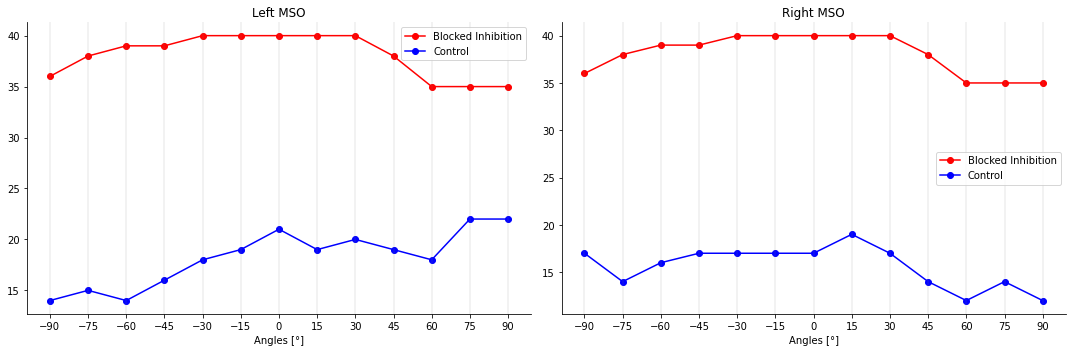

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[1].set_title("Right MSO")
ax[0].set_title("Left MSO")
#ax[0].set_ylabel("Absolute Spikes")

ax[1].plot(angles,results_r_MSO[0],"ro-", label = "Blocked Inhibition")
ax[1].plot(angles,results_r_MSO[1],"bo-", label = "Control")
ax[0].plot(angles,results_l_MSO[0],"ro-", label = "Blocked Inhibition")
ax[0].plot(angles,results_l_MSO[1],"bo-", label = "Control")

for i in range(len(angles)):
    ax[0].axvline(angles[i], linewidth = 0.2, color = 'grey')
    ax[1].axvline(angles[i], linewidth = 0.2, color = 'grey')

ax[0].set_xlabel("Angles [°]")
ax[0].set_xticks(angles)
ax[0].legend()
ax[0].spines['top'].set_visible(False) 
ax[0].spines['right'].set_visible(False)

ax[1].set_xlabel("Angles [°]")
ax[1].set_xticks(angles)
ax[1].legend()
ax[1].spines['top'].set_visible(False) 
ax[1].spines['right'].set_visible(False)
fig.tight_layout()
#plt.savefig('all')

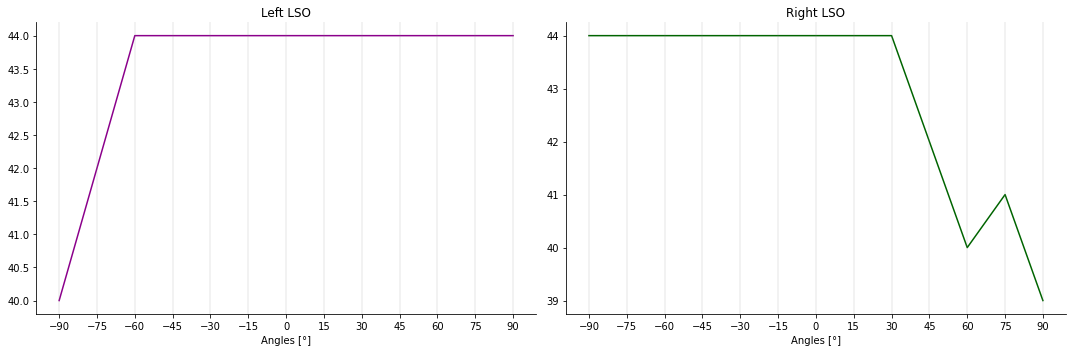

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))


ax[1].set_title("Right LSO")
ax[0].set_title("Left LSO")
#ax[0].set_ylabel("Absolute Spikes")

ax[1].plot(angles,results_r_LSO,"darkgreen")
ax[0].plot(angles,results_l_LSO, "darkmagenta")

for i in range(len(angles)):
    ax[0].axvline(angles[i], linewidth = 0.2, color = 'grey')
    ax[1].axvline(angles[i], linewidth = 0.2, color = 'grey')

ax[0].set_xlabel("Angles [°]")
ax[0].set_xticks(angles)
ax[0].spines['top'].set_visible(False) 
ax[0].spines['right'].set_visible(False)

ax[1].set_xlabel("Angles [°]")
ax[1].set_xticks(angles)
ax[1].spines['top'].set_visible(False) 
ax[1].spines['right'].set_visible(False)
fig.tight_layout()
#plt.savefig('all')

Text(0.5, 0, 'Time (ms)')

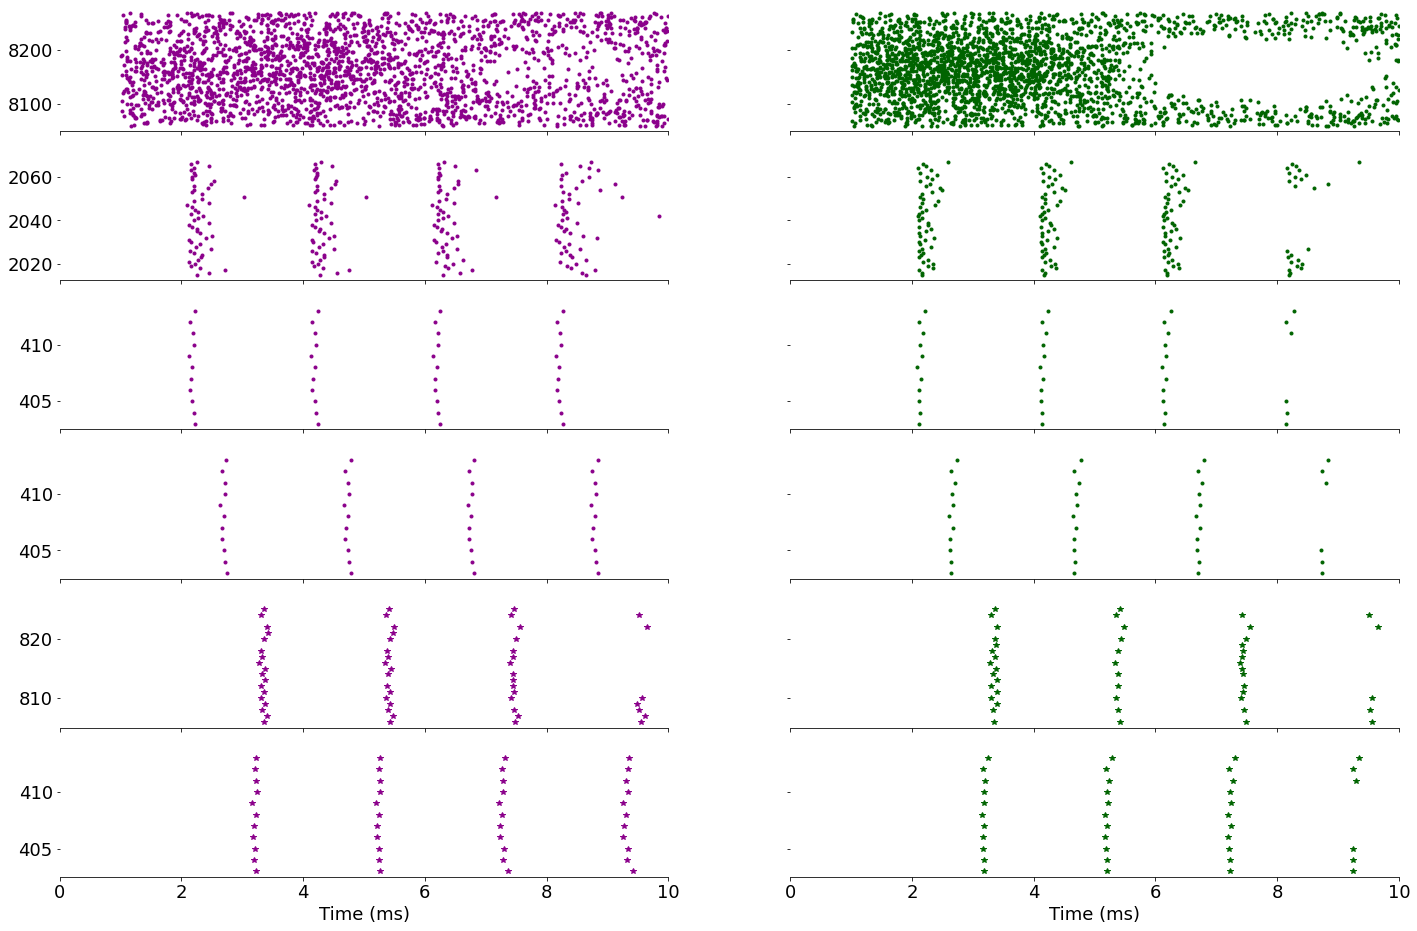

In [16]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

lim = 10

fig, ax = plt.subplots(6,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].plot(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)], data_l['senders'][np.where(data_l['senders'] < id_l_SBC1)] - id_l_ANF1, ".", color = 'darkmagenta')


ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]  - id_l_SBC1, ".", color = 'darkmagenta')


ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]  - id_l_GBC1, ".", color = 'darkmagenta')


ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))] - id_l_MNTBC1, ".", color = 'darkmagenta')

ax[4,0].spines['top'].set_visible(False)
ax[4,0].spines['right'].set_visible(False)
ax[4,0].spines['left'].set_visible(False)
ax[4,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MSO1) & (data_l['senders'] < id_l_LSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MSO1) & (data_l['senders'] < id_l_LSO1))] - id_l_MSO1, "*", color = 'darkmagenta')

ax[5,0].spines['top'].set_visible(False)
ax[5,0].spines['right'].set_visible(False)
ax[5,0].spines['left'].set_visible(False)
ax[5,0].plot(data_l['times'][np.where((data_l['senders'] >= id_l_LSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_LSO1))] - id_l_LSO1, "*", color = 'darkmagenta')
ax[5,0].set_xlabel("Time (ms)")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].plot(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)], data_r['senders'][np.where(data_r['senders'] < id_r_SBC1)] - id_r_ANF1, ".", color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))] - id_r_SBC1, ".", color = 'darkgreen')


ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))] - id_r_GBC1, ".", color = 'darkgreen')


ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))] - id_r_MNTBC1, ".", color = 'darkgreen')


ax[4,1].spines['top'].set_visible(False)
ax[4,1].spines['right'].set_visible(False)
ax[4,1].spines['left'].set_visible(False)
ax[4,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MSO1) & (data_r['senders'] < id_r_LSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MSO1) & (data_r['senders'] < id_r_LSO1))] - id_r_MSO1, "*", color = 'darkgreen')

ax[5,1].spines['top'].set_visible(False)
ax[5,1].spines['right'].set_visible(False)
ax[5,1].spines['left'].set_visible(False)
ax[5,1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_LSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_LSO1))] - id_r_LSO1, "*", color = 'darkgreen')
ax[5,1].set_xlabel("Time (ms)")

#plt.savefig('plot.png', transparent=True)

Text(0.5, 0, 'Time (ms)')

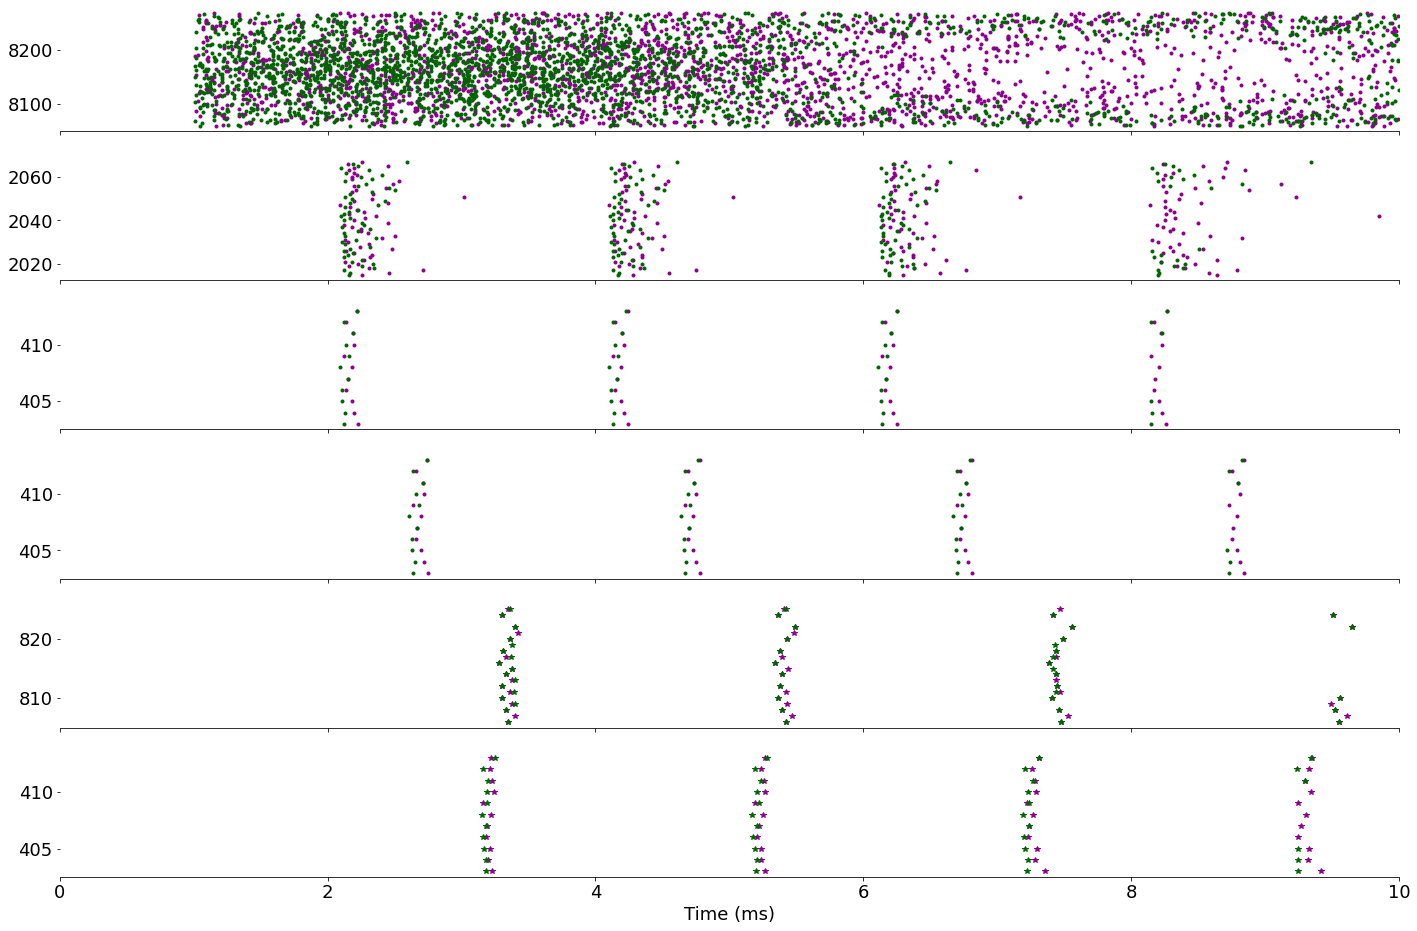

In [17]:
fig, ax = plt.subplots(6, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].plot(data_l['times'][np.where(data_l['senders'] < id_l_SBC1)], data_l['senders'][np.where(data_l['senders'] < id_l_SBC1)] - id_l_ANF1, ".", color = 'darkmagenta')


ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].plot(data_l['times'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_SBC1) & (data_l['senders'] < id_l_GBC1))]  - id_l_SBC1, ".", color = 'darkmagenta')


ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].plot(data_l['times'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))], data_l['senders'][np.where((data_l['senders'] >= id_l_GBC1) & (data_l['senders'] < id_l_MNTBC1))]  - id_l_GBC1, ".", color = 'darkmagenta')


ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[3].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MNTBC1) & (data_l['senders'] < id_l_MSO1))] - id_l_MNTBC1, ".", color = 'darkmagenta')

ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].spines['left'].set_visible(False)
ax[4].plot(data_l['times'][np.where((data_l['senders'] >= id_l_MSO1) & (data_l['senders'] < id_l_LSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_MSO1) & (data_l['senders'] < id_l_LSO1))] - id_l_MSO1, "*", color = 'darkmagenta')

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].plot(data_l['times'][np.where((data_l['senders'] >= id_l_LSO1))], data_l['senders'][np.where((data_l['senders'] >= id_l_LSO1))] - id_l_LSO1, "*", color = 'darkmagenta')
ax[5].set_xlabel("Time (ms)")

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].plot(data_r['times'][np.where(data_r['senders'] < id_r_SBC1)], data_r['senders'][np.where(data_r['senders'] < id_r_SBC1)] - id_r_ANF1, ".", color = 'darkgreen')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].plot(data_r['times'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_SBC1) & (data_r['senders'] < id_r_GBC1))] - id_r_SBC1, ".", color = 'darkgreen')


ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].plot(data_r['times'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))], data_r['senders'][np.where((data_r['senders'] >= id_r_GBC1) & (data_r['senders'] < id_r_MNTBC1))] - id_r_GBC1, ".", color = 'darkgreen')


ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].spines['left'].set_visible(False)
ax[3].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MNTBC1) & (data_r['senders'] < id_r_MSO1))] - id_r_MNTBC1, ".", color = 'darkgreen')


ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].spines['left'].set_visible(False)
ax[4].plot(data_r['times'][np.where((data_r['senders'] >= id_r_MSO1) & (data_r['senders'] < id_r_LSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_MSO1) & (data_r['senders'] < id_r_LSO1))] - id_r_MSO1, "*", color = 'darkgreen')

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].plot(data_r['times'][np.where((data_r['senders'] >= id_r_LSO1))], data_r['senders'][np.where((data_r['senders'] >= id_r_LSO1))] - id_r_LSO1, "*", color = 'darkgreen')
ax[5].set_xlabel("Time (ms)")

#plt.savefig('plot.png', transparent=True)

In [18]:
bin_dim = 0.01 #ms

hist_r_ANFs = np.zeros(int(time_sim/bin_dim))
hist_l_ANFs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_anf:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_ANFs = hist_r_ANFs + s_r
    
for i in ac_l_anf:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_ANFs = hist_l_ANFs + s_l
    
hist_r_SBCs = np.zeros(int(time_sim/bin_dim))
hist_l_SBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_sbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_SBCs = hist_r_SBCs + s_r
    
for i in ac_l_sbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_SBCs = hist_l_SBCs + s_l
    
hist_r_GBCs = np.zeros(int(time_sim/bin_dim))
hist_l_GBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_gbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_GBCs = hist_r_GBCs + s_r
    
for i in ac_l_gbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_GBCs = hist_l_GBCs + s_l

hist_r_MNTBCs = np.zeros(int(time_sim/bin_dim))
hist_l_MNTBCs = np.zeros(int(time_sim/bin_dim))

for i in ac_r_mntbc:
    t_r = data_r['times'][np.where(data_r['senders'] == i)]
    s_r, bins = np.histogram(t_r, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_r_MNTBCs = hist_r_MNTBCs + s_r
    
    
for i in ac_l_mntbc:
    t_l = data_l['times'][np.where(data_l['senders'] == i)]
    s_l, bins = np.histogram(t_l, np.arange(0,time_sim+bin_dim,bin_dim))
    hist_l_MNTBCs = hist_l_MNTBCs + s_l

Text(0.5, 0, 'Time [ms]')

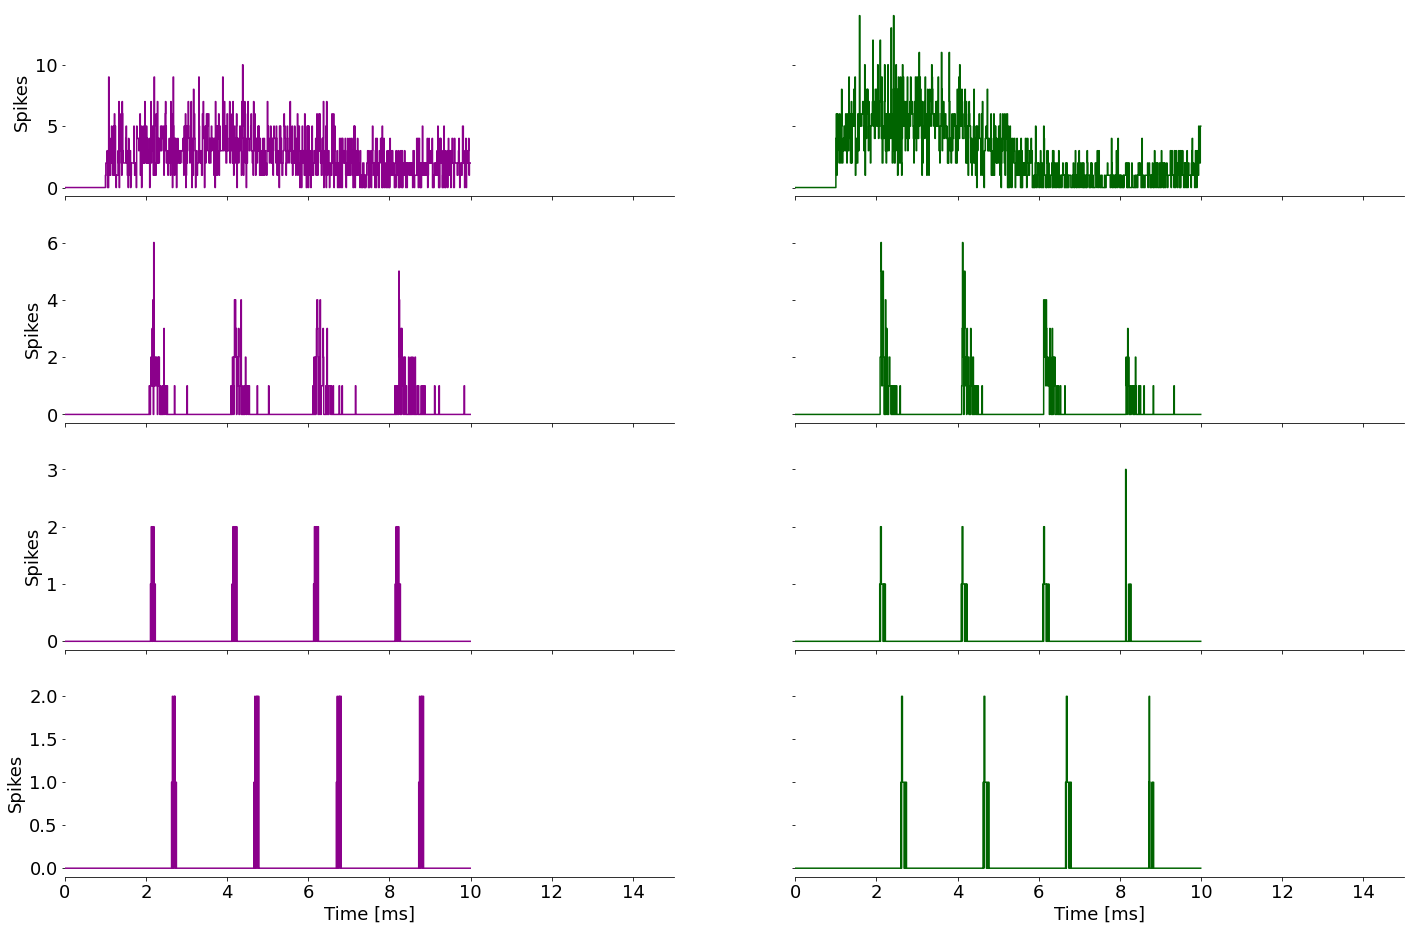

In [19]:
lim = 15

fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs, color = 'darkmagenta')
ax[0,0].set_ylabel("Spikes")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs, color = 'darkmagenta')
ax[1,0].set_ylabel("Spikes")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs, color = 'darkmagenta')
ax[2,0].set_ylabel("Spikes")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs, color = 'darkmagenta')
ax[3,0].set_ylabel("Spikes")
ax[3,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs, color = 'darkgreen')
ax[3,1].set_xlabel("Time [ms]")

In [20]:
hist_r_ANFs = hist_r_ANFs/len(ac_r_anf)
hist_l_ANFs = hist_l_ANFs/len(ac_l_anf)

hist_r_SBCs = hist_r_SBCs/len(ac_r_sbc)
hist_l_SBCs = hist_l_SBCs/len(ac_l_sbc)

hist_r_GBCs = hist_r_GBCs/len(ac_r_gbc)
hist_l_GBCs = hist_l_GBCs/len(ac_l_gbc)

hist_r_MNTBCs = hist_r_MNTBCs/len(ac_r_mntbc)
hist_l_MNTBCs = hist_l_MNTBCs/len(ac_l_mntbc)

Text(0.5, 0, 'Time [ms]')

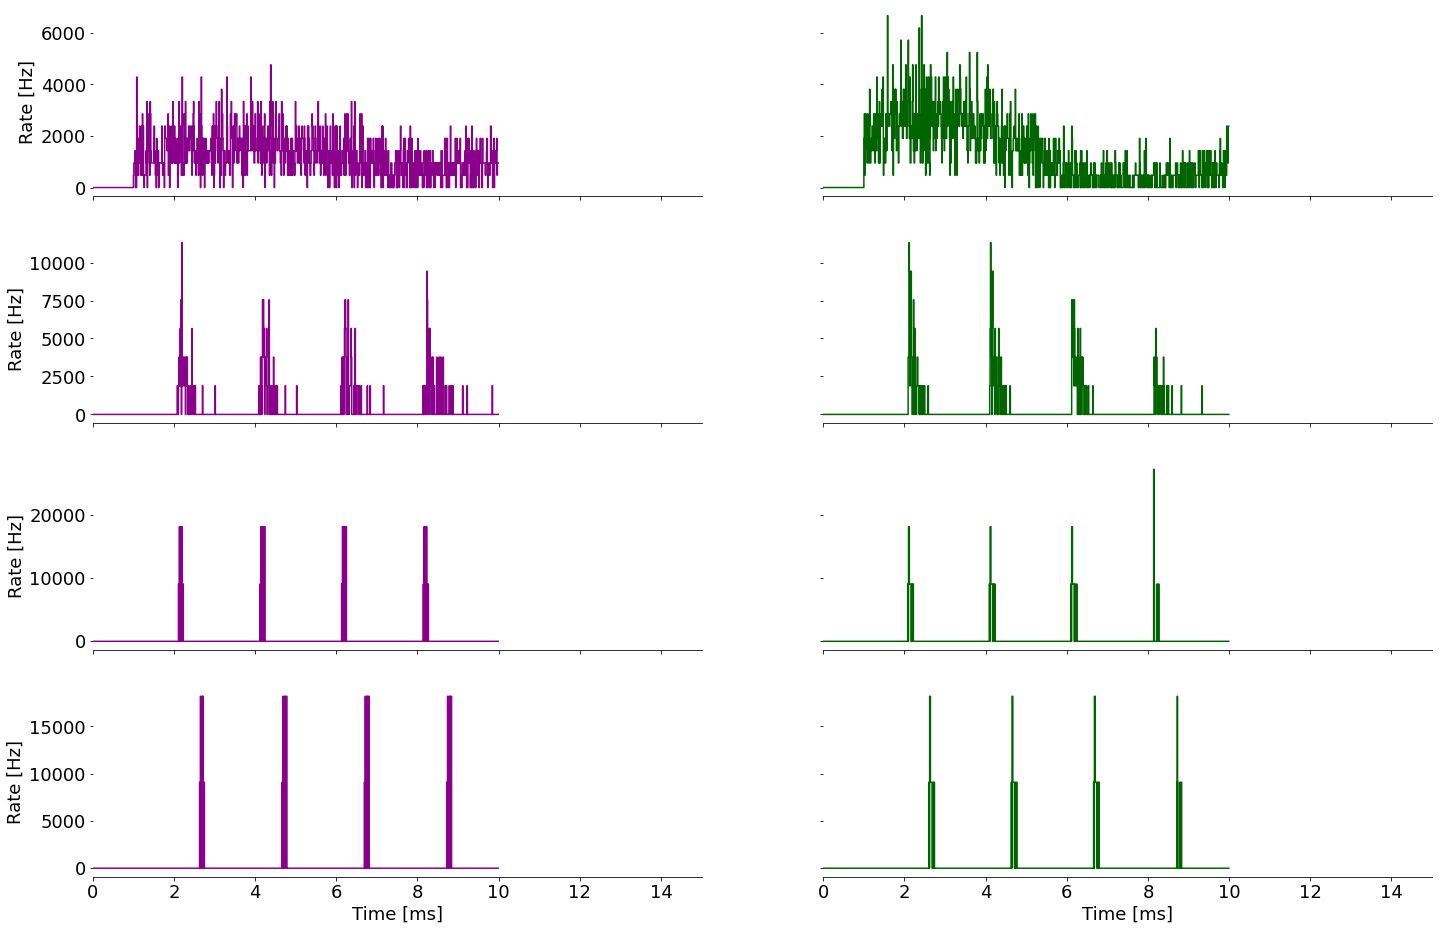

In [21]:
fig, ax = plt.subplots(4,2, figsize = (24,16), sharex = True, sharey = 'row')
plt.xlim(0,lim)

ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].step(bins[:-1], hist_l_ANFs*1000/bin_dim, color = 'darkmagenta')
ax[0,0].set_ylabel("Rate [Hz]")

ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['left'].set_visible(False)
ax[1,0].step(bins[:-1], hist_l_SBCs*1000/bin_dim, color = 'darkmagenta')
ax[1,0].set_ylabel("Rate [Hz]")

ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['left'].set_visible(False)
ax[2,0].step(bins[:-1], hist_l_GBCs*1000/bin_dim, color = 'darkmagenta')
ax[2,0].set_ylabel("Rate [Hz]")

ax[3,0].spines['top'].set_visible(False)
ax[3,0].spines['right'].set_visible(False)
ax[3,0].spines['left'].set_visible(False)
ax[3,0].step(bins[:-1], hist_l_MNTBCs*1000/bin_dim, color = 'darkmagenta')
ax[3,0].set_ylabel("Rate [Hz]")
ax[3,0].set_xlabel("Time [ms]")

ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].step(bins[:-1], hist_r_ANFs*1000/bin_dim, color = 'darkgreen')

ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].step(bins[:-1], hist_r_SBCs*1000/bin_dim, color = 'darkgreen')

ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['left'].set_visible(False)
ax[2,1].step(bins[:-1], hist_r_GBCs*1000/bin_dim, color = 'darkgreen')

ax[3,1].spines['top'].set_visible(False)
ax[3,1].spines['right'].set_visible(False)
ax[3,1].spines['left'].set_visible(False)
ax[3,1].step(bins[:-1], hist_r_MNTBCs*1000/bin_dim, color = 'darkgreen')
ax[3,1].set_xlabel("Time [ms]")